In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import math
import numpy as np
import random
import pandas as pd
import nltk
import glob
import regex as re
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    TrainingArguments, Trainer
)

ModuleNotFoundError: No module named 'torch'

In [ ]:
load_data_train = load_dataset('csv', data_files ='./cnn_dailymail/train.csv')
load_data_valid = load_dataset('csv', data_files ='./cnn_dailymail/validation.csv')

#i = 0
dataset_train = load_data_train['train']
dataset_valid = load_data_valid['train']

Using custom data configuration default-01b8410d489fd10c
Reusing dataset csv (C:\Users\luka2\.cache\huggingface\datasets\csv\default-01b8410d489fd10c\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-20a9484be1a2dddd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\luka2\.cache\huggingface\datasets\csv\default-20a9484be1a2dddd\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset_train[0]

{'id': '0001d1afc246a7964130f43ae940af6bc6c57f01',
 'article': "By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through con

In [ ]:
from datasets import load_dataset

In [ ]:
#articles = []
#highlights = []
load_data_train = load_dataset('csv', data_files ='./cnn_dailymail/train.csv')
load_data_valid = load_dataset('csv', data_files ='./cnn_dailymail/validation.csv')

#i = 0
dataset_train = load_data_train['train']
dataset_valid = load_data_valid['train']
articles_train = dataset_train['article'][:28000]
highlights_train = dataset_train['highlights'][:28000]
articles_valid = dataset_valid['article'][:1500]
highlights_valid = dataset_valid['highlights'][:1500]

#i = 0
#for article in articles_train:
#    article = re.findall(r"[\w']+", article)
#    articles_train[i] = article
#    i += 1
#j = 0
#for highlight in highlights_train:
#    highlight = re.findall(r"[\w']+", highlight)
#    highlights_train[j] = highlight
#    j += 1



Using custom data configuration default-a5d7f0e1576a416d
Reusing dataset csv (/home/jpavicic/.cache/huggingface/datasets/csv/default-a5d7f0e1576a416d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-c845ff500875c8c8
Reusing dataset csv (/home/jpavicic/.cache/huggingface/datasets/csv/default-c845ff500875c8c8/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

Wed Jun 29 19:48:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0 Off |                  N/A |
|  0%   40C    P8    19W / 240W |     19MiB /  7981MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

DATASET

In [ ]:
class SummarizationDataset(Dataset):
  def __init__(
      self,
      data_articles: list,
      data_highlights: list,
      tokenizer = T5Tokenizer,
      article_max_token_len : int = 512,
      highlight_max_token_len : int = 128
  ):
      self.tokenizer = tokenizer
      self.data_articles = data_articles
      self.data_highlights = data_highlights
      self.article_max_token_len = article_max_token_len
      self.highlight_max_token_len = highlight_max_token_len

  def __len__(self):
      return len(self.data_articles)

  def __getitem__(self, index : int):

    article = self.data_articles[index]
    highlight = self.data_highlights[index]

    article_encoding = tokenizer(
        article,
        max_length = self.article_max_token_len,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = 'pt'
    )
    highlight_encoding = tokenizer(
        highlight,
        max_length = self.highlight_max_token_len,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = 'pt'
    )

    labels = highlight_encoding['input_ids']
    labels[labels == 0] = -100

    return dict(
        article = article,
        highlight = highlight,
        input_ids = article_encoding['input_ids'].flatten(),
        attention_mask = article_encoding['attention_mask'].flatten(),
        labels = labels.flatten(),
        labels_attention_mask = highlight_encoding['attention_mask'].flatten()
    )

In [ ]:
MODEL_NAME = 't5-small'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length = 512)

In [ ]:
article_max_token_len = 512
highlight_max_token_len = 128

ds_train = SummarizationDataset(articles_train, highlights_train, tokenizer, article_max_token_len, highlight_max_token_len)
ds_valid = SummarizationDataset(articles_valid, highlights_valid, tokenizer, article_max_token_len, highlight_max_token_len)

In [ ]:
ds_train[4]['labels']

tensor([23705,  2037,   420,    13,  3815,   555,   227,     3, 19423,  1369,
           44,  4712,   202,   189,   127,   855,     3,     5,  2737, 12823,
            6, 17836,   896,     6, 20976,  1846,    11,   205, 10936,  1306,
           66,  2328,   166,   979,    13,     8,   774,     3,     5,  7351,
           18,    77,  6585,    52,  5199,  1008,    15,  7586,     3,     9,
            3,   547,    18,    17,  5206,    38,  2158,   524,  5437,     3,
          189, 12380, 16233,    15,     3, 24279,     3,     5,  4871,     7,
           21,   933,    17,     7,  1334,    11,  7271,    32,  6372,     3,
            5,   638,  2169,   651,    87, 18304,    26,  2590,    11,  3525,
         1483,    87, 14714,  3833,    15,   321,   414,    16, 14924,     3,
            5,    71,  1480,  7872,   938,  3552,   293,  1288,   177,   725,
        18584, 14799,   386,   979,   581,  4185, 10279,     3,     5,     1,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [ ]:
batch_size = 8
dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True, num_workers = 2)
dl_valid = DataLoader(ds_valid, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr = 0.00005)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

395

In [ ]:
TOKENIZERS_PARALLELISM = True

In [ ]:
checkpoint = torch.load('./model_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:

epochs = 20
losses_train = []
losses_valid = []
train_losses_per_epoch = []
valid_losses_per_epoch = []
print("bzzz")

for epoch in range(epochs):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_list': train_losses_per_epoch,
            'validation_loss_list': valid_losses_per_epoch
    }, './model_checkpoint.pt')
    running_loss = 0.0
    losses_train = []
    losses_valid = []
    model.train()
    for i, data in enumerate(dl_train, 0):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels =  data['labels'].to(device)
        decoder_attention_mask = data['labels_attention_mask'].to(device)
        optimizer.zero_grad()
        output_loss = model(input_ids = input_ids, attention_mask = attention_mask, decoder_attention_mask = decoder_attention_mask, labels = labels).loss
        losses_train.append(output_loss.item())

        output_loss.backward()
        optimizer.step()

        running_loss += output_loss.item()

        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:2d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

    validation_running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, data_val in enumerate(dl_valid, 0):
            input_ids_val = data_val['input_ids'].to(device)
            attention_mask_val = data_val['attention_mask'].to(device)
            decoder_attention_mask_val = data_val['labels_attention_mask'].to(device)
            labels_val =  data_val['labels'].to(device)
            output_loss_val = model(input_ids = input_ids_val, attention_mask = attention_mask_val, decoder_attention_mask = decoder_attention_mask_val, labels = labels_val).loss
            losses_valid.append(output_loss_val.item())
            validation_running_loss += output_loss_val.item()
            if j % 50 == 49:
                print(f'[{epoch + 1}, {j + 1:2d}] validation_loss: {validation_running_loss / 50:.3f}')
                validation_running_loss = 0.0
    train_losses_per_epoch.append(losses_train)
    valid_losses_per_epoch.append(losses_valid)
    print(f'Epoch {epoch + 1} / {epochs} train_loss : {output_loss} validation_loss: {output_loss_val}')



bzzz
[1, 500] loss: 2.148
[1, 1000] loss: 2.084
[1, 1500] loss: 2.063
[1, 2000] loss: 2.060
[1, 2500] loss: 2.081
[1, 3000] loss: 2.018
[1, 3500] loss: 2.025
[1, 50] validation_loss: 1.867
[1, 100] validation_loss: 1.786
[1, 150] validation_loss: 1.800
Epoch 1 / 20 train_loss : 1.6262794733047485 validation_loss: 1.8668029308319092
[2, 500] loss: 2.004
[2, 1000] loss: 2.008
[2, 1500] loss: 2.025
[2, 2000] loss: 1.995
[2, 2500] loss: 2.002
[2, 3000] loss: 2.001
[2, 3500] loss: 1.992
[2, 50] validation_loss: 1.793
[2, 100] validation_loss: 1.825
[2, 150] validation_loss: 1.863
Epoch 2 / 20 train_loss : 1.564241886138916 validation_loss: 1.642137885093689
[3, 500] loss: 1.975
[3, 1000] loss: 1.990
[3, 1500] loss: 1.957
[3, 2000] loss: 1.970
[3, 2500] loss: 1.980
[3, 3000] loss: 1.958
[3, 3500] loss: 1.981
[3, 50] validation_loss: 1.807
[3, 100] validation_loss: 1.876
[3, 150] validation_loss: 1.749
Epoch 3 / 20 train_loss : 1.6541541814804077 validation_loss: 1.8750759363174438
[4, 500] l

# Novi odjeljak

# Novi odjeljak

In [ ]:
times_train = [i for i in range(0, len(losses_train))]

In [ ]:
len(losses_valid)

In [ ]:
times_valid = [i for i in range(0, len(losses_valid))]

In [ ]:
import matplotlib.pyplot as plt

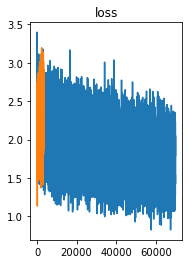

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax0.plot(times_train, losses_train, label='train')
ax0.plot(times_valid, losses_valid, label='val')

In [ ]:
new_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)

In [ ]:
checkpoint = torch.load('./model_checkpoint.pt')
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
def summarizeText(text):
  article_encoding = tokenizer(
      text,
      max_length = 512,
      padding = 'max_length',
      truncation = True,
      return_attention_mask = True,
      add_special_tokens = True,
      return_tensors = 'pt'
  )

  generated_ids = new_model.generate(
      input_ids = article_encoding['input_ids'],
      attention_mask = article_encoding['attention_mask'],
      max_length = 150,
      num_beams = 2,
      repetition_penalty = 2.5,
      length_penalty = 1.0,
      early_stopping = True
  )

  preds = [
           tokenizer.decode(gen_id, skip_special_tokens = True, clean_up_tokenization_spaces = True)
           for gen_id in generated_ids
  ]
  return "".join(preds)

In [ ]:
sample_row = articles_train[2]
#text = 'South African authorities are investigating the deaths of at least 22 young people in a nightclub. The victims were found strewn across floors and tables the Enyobeni Tavern in the coastal town of East London. The bodies were taken to mortuaries, where post-mortem examinations - including toxicology tests - will seek to establish a cause of death. South African President Cyril Ramaphosa expressed his "deepest condolences" to families of the victims. "This tragedy is made even more grave by its occurrence during Youth Month - a time during which we... advocate and advance opportunities for improved socio-economic conditions for the youth of our nation," he said in a tweet. Oscar Mabuyane, premier of East Cape Province where the tragedy happened, did not give possible reasons for the deaths, but condemned the "unlimited consumption of liquor". Speaking at the scene, he said: "You cannot just trade in the middle of society like this and think that young people are not going to experiment." The incident occurred in the early hours of Sunday. Those found dead were aged between 18 and 20. A provincial safety official told AFP news agency that a stampede had been ruled out as the cause of death as there were "no visible wounds". "Forensic [investigators] will take samples and test to see if there was any poisoning of any sort," Unathi Binqose said.'
text = sample_row
#text = 'Stam spices up Man Utd encounter\n \nAC Milan defender Jaap Stam says Manchester United "know they made a mistake" by selling him in 2001.\n\nThe sides meet at Old Trafford in the Champions League game on Wednesday and the 32-year-old\'s Dutchman\'s presence is sure to add spice to the fixture. "United made a mistake in selling me," Stam told Uefa\'s Champions magazine. "I was settled at Manchester United, but they wanted to sell me. If a club want to sell you, there is nothing you can do. You can be sold like cattle." Sir Alex Ferguson surprised the football world - and Stam - by selling the Dutchman to Lazio for 16.5m in August 2001. The decision came shortly after Stam claimed in his autobiography that Ferguson had tapped him up when he was at PSV Eindhoven. But Ferguson insisted he sold the defender because the transfer fee was too good to refuse for a player past his prime. The affair still rankles with the Dutchman.\n\n"I was settled at Manchester United, I had even just ordered a new kitchen, but they wanted to sell me," he said. "In what other industry can a good employee be ushered out the door against their wishes? "Of course, you can refuse to go, but then the club have the power to put you on the bench. I don\'t agree that players control the game. "There have been opportunities to confront them in the newspapers, but I have turned them down. What\'s the point?"\n\nWednesday\'s game at Old Trafford will provide an intriguing confrontation between United\'s young attackers Wayne Rooney and Cristiano Ronaldo and Milan\'s veteran defence of Stam, Paolo Maldini, Cafu and Alessandro Costacurta. Stam says Rooney\'s teenage stardom is in stark contract to his own start in the game. "We can\'t all be Wayne Rooneys - at his age I was training to be an electrician and thought my chance of becoming a professional footballer had gone," he said. "Starting late can be a good thing. Some kids who start early get bored. "I had my youth - having fun, drinking beers, blowing up milk cannisters. It sounds strange but it\'s a tradition where I grew up in Kampen - and I had done all the things I wanted to do."\n'
model_summary = summarizeText(text)
text

"A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he received a text message. As he was reading or replying to it, he veered across the road while driving round a bend and smashed into Rachel Titley’s car coming the other way. Craig Eccleston-Todd, 27 (left) was using his mobile phone when he crashed head-on into the car being driven by Rachel Titley, 28 (right). She died later from her injuries . The head-on crash took place in October 2013. Mr Eccleston-Todd's car was barely recognisable (pictured) Police said Eccleston-Todd had drunk at least three or four pints of beer before getting behind the wheel. He was found guilty of causing death by dangerous driving at Portsmouth Crown Court yesterday. Miss Titley, a 28-year-old solicitor’s clerk from Cowes, Isle of Wight, had also spent the evening with friends at a pub but had not drunk any alcoho

In [ ]:
model_summary

"Craig Eccleston-Todd, 27, was using his mobile phone when he crashed into Rachel Titley's car. As he was reading or replying to text message he veered across road. He smashed into the 28-year-old solicitor's clerk from Cowes, Isle of Wight, coming the other way. Miss Titley died later from her injuries in hospital. Mr Eccleston-Todd was found guilty of causing death by dangerous driving."

In [ ]:
highlights_train[2]

"Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titley's car, who died in hospital .\nPolice say he would have been over legal drink-drive limit at time of crash .\nHe was found guilty at Portsmouth Crown Court of causing death by dangerous driving ."

In [ ]:
load_data_test = load_dataset('csv', data_files ='./cnn_dailymail/test.csv')
dataset_test = load_data_test['train']

Using custom data configuration default-9f4275294e83e56b
Reusing dataset csv (/home/jpavicic/.cache/huggingface/datasets/csv/default-9f4275294e83e56b/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions = []
references = []

In [ ]:
for i in range(0, 10):
    predictions.append(summarizeText(dataset_test['article'][i]))
    references.append(dataset_test['highlights'][i])

In [ ]:
import datasets

In [ ]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
rouge = datasets.load_metric('rouge')
results = rouge.compute(predictions=predictions, references=references)

In [ ]:
from evaluate-metric import evaluate

SyntaxError: invalid syntax (2538280995.py, line 1)

In [ ]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=predictions, references=references)

NameError: name 'evaluate' is not defined

In [ ]:
from rouge_score import rouge_scorer, scoring

In [ ]:
rouge_types = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types)

In [ ]:
for ref, pred in zip(references, predictions):
    score = scorer.score(ref, pred)

    scores.append(score)

In [ ]:
scores = []

In [ ]:
scores[2]

{'rouge1': Score(precision=0.42857142857142855, recall=0.45454545454545453, fmeasure=0.4411764705882353),
 'rouge2': Score(precision=0.23529411764705882, recall=0.25, fmeasure=0.24242424242424243),
 'rougeL': Score(precision=0.3142857142857143, recall=0.3333333333333333, fmeasure=0.3235294117647059),
 'rougeLsum': Score(precision=0.34285714285714286, recall=0.36363636363636365, fmeasure=0.3529411764705882)}

In [ ]:
for result in results.values():
    print(result)

AggregateScore(low=Score(precision=0.29887529787312844, recall=0.3776635676922718, fmeasure=0.3327264690197331), mid=Score(precision=0.40162339099698996, recall=0.45872345580037455, fmeasure=0.4175664677109717), high=Score(precision=0.5057110116479723, recall=0.5415608028008753, fmeasure=0.49610460121160604))
AggregateScore(low=Score(precision=0.11694584670306699, recall=0.13831710861602167, fmeasure=0.12625636128392762), mid=Score(precision=0.18968356399842182, recall=0.20776775586650315, fmeasure=0.1937001888776836), high=Score(precision=0.2657493345284659, recall=0.27545491114347037, fmeasure=0.2618865553228871))
AggregateScore(low=Score(precision=0.21245835042012934, recall=0.25871850550156233, fmeasure=0.23322135383523043), mid=Score(precision=0.29046188359309966, recall=0.3343840146038243, fmeasure=0.304211817246241), high=Score(precision=0.3806144723941489, recall=0.40057833637330903, fmeasure=0.371441522308866))
AggregateScore(low=Score(precision=0.2575015712904361, recall=0.31